<a href="https://colab.research.google.com/github/shreyans312/CSoT-CS_Research_ARIES_X_ACESACM/blob/main/Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q torchinfo


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import random
import time

%matplotlib inline

In [4]:
def set_seeds():
  SEED_VALUE = 42
  random.seed(SEED_VALUE)
  np.random.seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seeds()

In [5]:
raw_transform = transforms.Compose([transforms.ToTensor()])
train_set_raw = datasets.FashionMNIST(root='F_MNIST_data', download=True, train=True, transform=raw_transform)
all_pixels = torch.cat([img.view(-1) for img, _ in train_set_raw])
mean = all_pixels.mean().item()
std = all_pixels.std().item()
print(f'Mean: {mean:.3f}, Std deviation: {std:.3f}')


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_set = datasets.FashionMNIST(root='F_MNIST_data', download=True, train=True, transform=transform)
val_set = datasets.FashionMNIST(root='F_MNIST_data', download=True, train=False, transform=transform)

print("Total training images:", len(train_set))
print("Total val images:", len(val_set))

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.03MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 138kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.7MB/s]


Mean: 0.286, Std deviation: 0.353
Total training images: 60000
Total val images: 10000


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=64)

In [7]:
class_mapping = {
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

# **Data Visualisation**

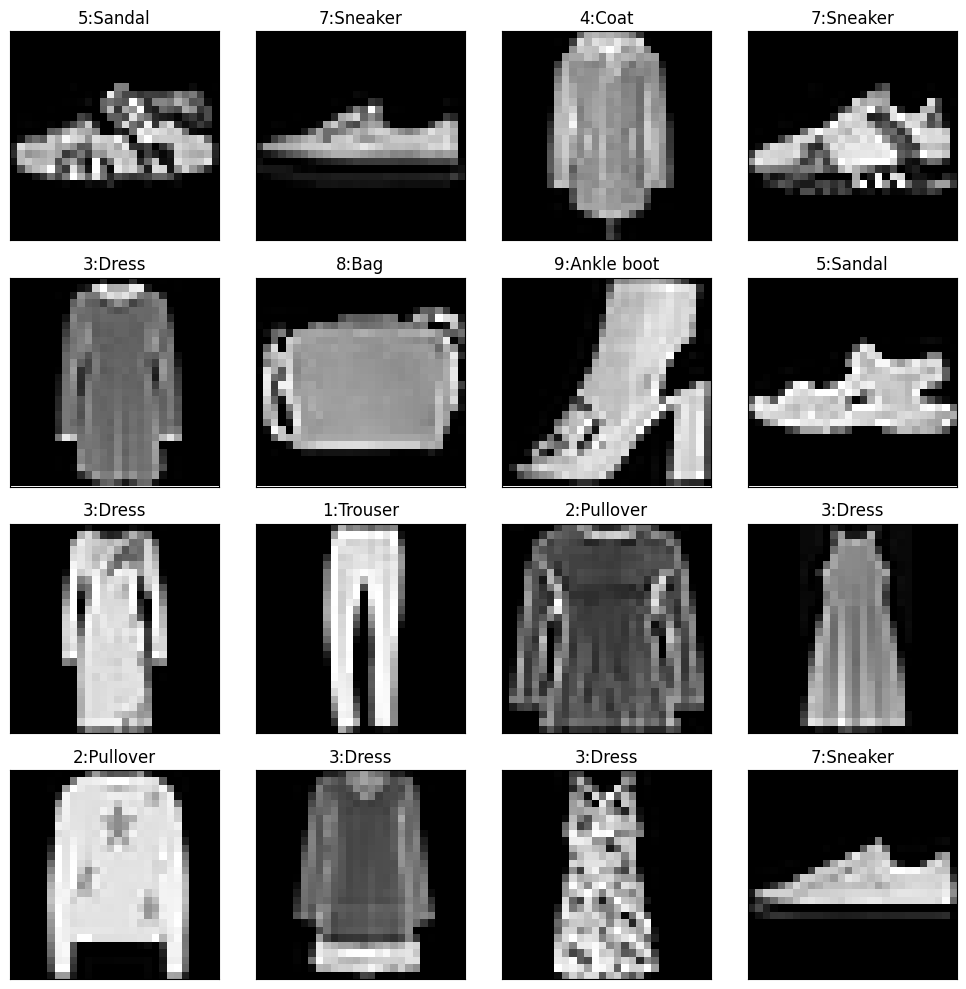

In [8]:
def visualize_images(trainloader, num_images=20):
  fig = plt.figure(figsize=(10,10))
  images, labels = next(iter(trainloader))
  num_rows = 4
  num_cols = int(np.ceil(num_images/num_rows))
  for idx in range(min(num_images, len(images))):
    image, label = images[idx], labels[idx]
    ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(image), cmap="gray")
    ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

  fig.tight_layout()
  plt.show()

visualize_images(train_loader, num_images=16)

# **Building the neural network**

In [9]:
class MLP(nn.Module):
  def __init__(self, num_classes):
    super().__init__()

    self.fc0 = nn.Linear(784, 512)
    self.bn0 = nn.BatchNorm1d(512)

    self.fc1 = nn.Linear(512, 256)
    self.bn1 = nn.BatchNorm1d(256)

    self.fc2 = nn.Linear(256, 128)
    self.bn2 = nn.BatchNorm1d(128)

    self.fc3 = nn.Linear(128, 64)
    self.bn3 = nn.BatchNorm1d(64)

    self.fc4 = nn.Linear(64, num_classes)

    self.dropout = nn.Dropout(p=0.2) # To prevent overfitting

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = F.relu(self.bn0(self.fc0(x)))
    x = self.dropout(x)

    x = F.relu(self.bn1(self.fc1(x)))

    x = F.relu(self.bn2(self.fc2(x)))
    x = self.dropout(x)

    x = F.relu(self.bn3(self.fc3(x)))

    x = F.log_softmax(self.fc4(x), dim=1)

    return x

mlp_model = MLP(num_classes=10)

In [10]:
print(summary(mlp_model, input_size=(1, 1, 28, 28), row_settings=["var_names"]))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

In [11]:
criterion = F.nll_loss # neg log likelihood loss
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

num_epochs = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# **Model Training**

In [12]:
def train(model, trainloader, criterion, optimizer, DEVICE):
  model.train()
  model.to(DEVICE)

  running_loss = 0
  correct_predictions = 0
  total_samples = 0

  for images, labels in trainloader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total_samples += labels.size(0)
    correct_predictions += (predicted == labels).sum().item()

  avg_loss = running_loss / len(trainloader)
  accuracy = correct_predictions * 100 / total_samples

  return avg_loss, accuracy

In [13]:
def validation(model, val_loader, criterion, DEVICE):
  model.eval()
  model.to(DEVICE)

  running_loss = 0
  correct_predictions = 0
  total_samples = 0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(DEVICE), labels.to(DEVICE)

      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()

      _, predicted = torch.max(outputs.data, dim=1)
      total_samples += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

  avg_loss = running_loss / len(val_loader)
  accuracy = correct_predictions * 100 / total_samples

  return avg_loss, accuracy

In [14]:
def main(model, trainloader, val_loader, epochs=5, DEVICE="cuda"):
  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  for epoch in range(epochs):
    train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, DEVICE)
    val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.3f} - Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.3f} - Val Accuracy: {val_accuracy:.2f}%")

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(range(1, epochs+1), train_losses, label='Train loss', marker='o')
  plt.plot(range(1, epochs+1), val_losses, label='Validation loss', marker='s')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training & Validation Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epochs+1), train_accuracies, label='Train accuracy', marker='o')
  plt.plot(range(1, epochs+1), val_accuracies, label='Validation accuracy', marker='s')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training & Validation Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

Epoch 01/40 - Train Loss: 0.539 - Train Accuracy: 80.70% - Val Loss: 0.418 - Val Accuracy: 84.87%
Epoch 02/40 - Train Loss: 0.415 - Train Accuracy: 85.24% - Val Loss: 0.369 - Val Accuracy: 86.52%
Epoch 03/40 - Train Loss: 0.379 - Train Accuracy: 86.31% - Val Loss: 0.361 - Val Accuracy: 86.93%
Epoch 04/40 - Train Loss: 0.354 - Train Accuracy: 87.22% - Val Loss: 0.373 - Val Accuracy: 86.40%
Epoch 05/40 - Train Loss: 0.334 - Train Accuracy: 88.00% - Val Loss: 0.339 - Val Accuracy: 87.81%
Epoch 06/40 - Train Loss: 0.319 - Train Accuracy: 88.40% - Val Loss: 0.328 - Val Accuracy: 88.33%
Epoch 07/40 - Train Loss: 0.303 - Train Accuracy: 88.98% - Val Loss: 0.341 - Val Accuracy: 87.63%
Epoch 08/40 - Train Loss: 0.292 - Train Accuracy: 89.18% - Val Loss: 0.312 - Val Accuracy: 88.52%
Epoch 09/40 - Train Loss: 0.281 - Train Accuracy: 89.64% - Val Loss: 0.329 - Val Accuracy: 87.86%
Epoch 10/40 - Train Loss: 0.272 - Train Accuracy: 89.92% - Val Loss: 0.316 - Val Accuracy: 88.79%
Epoch 11/40 - Train 

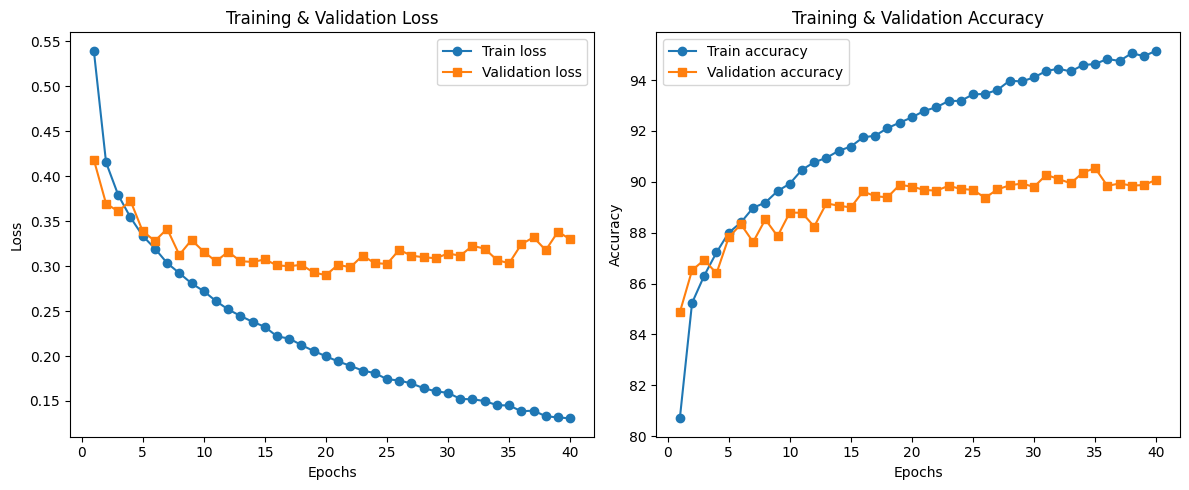

In [15]:
main(mlp_model, train_loader, val_loader, epochs=num_epochs, DEVICE=DEVICE)

#**Result Prediction**

AttributeError: 'int' object has no attribute 'items'

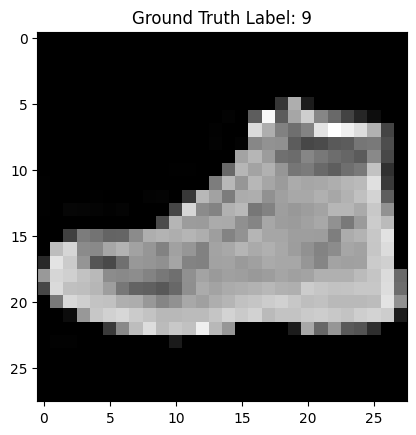

In [22]:
images, gt_labels = next(iter(val_loader))
rand_idx = random.choice(range(len(images)))
plt.imshow(images[rand_idx].squeeze(), cmap="gray")
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_idx])), fontdict=12)
plt.axis("off")
plt.show()

In [23]:
bold = f"\033[1m"
reset = f"\033[0m"

In [24]:
mlp_model.eval()

with torch.no_grad():
  batch_outputs = mlp_model(images.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()

prob_score_test_image = prob_score_batch[rand_idx]

pred_cls_id = prob_score_test_image.argmax()
print("Predictions for each class on the test image:\n")
for idx, cls_prob in enumerate(prob_score_test_image):
  if idx == pred_cls_id:
    print(f"\033[1mClass: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}\033[0m")
  else:
    print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")


Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.000
Class: 1 - Trouser, Probability: 0.000
Class: 2 - Pullover, Probability: 0.000
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.000
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.000
Class: 7 - Sneaker, Probability: 0.009
Class: 8 - Bag, Probability: 0.000
Class: 9 - Ankle boot, Probability: 0.991


# Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [26]:
def prediction_batch(model, batch_inputs):
  model.eval()
  batch_outputs = model(batch_inputs)

  with torch.no_grad():
    batch_probs = batch_outputs.softmax(dim=1)

  batch_cls_ids = batch_probs.argmax(dim=1)

  return batch_cls_ids.cpu()

In [27]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in val_loader:
  image_batch = image_batch.to(DEVICE)
  batch_pred_cls_id = prediction_batch(mlp_model, image_batch)

  val_predicted_labels.append(batch_pred_cls_id)
  val_target_labels.append(target_batch)

val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

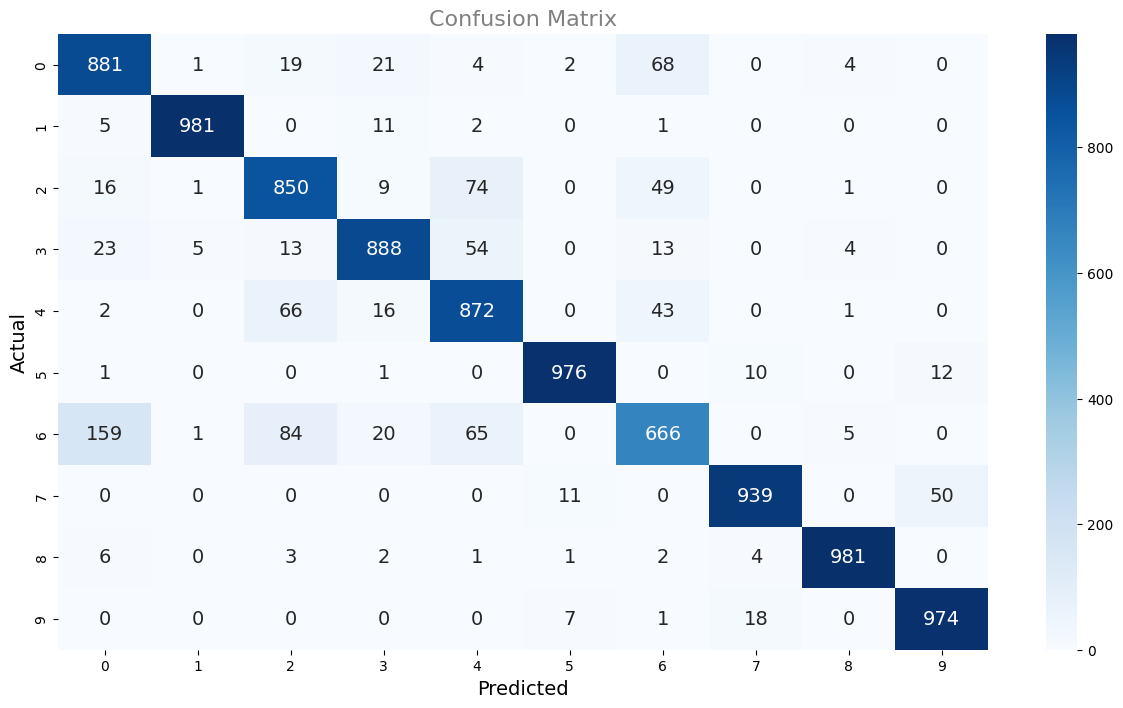

In [29]:
cm = confusion_matrix(y_true=val_target_labels, y_pred=val_predicted_labels)
plt.figure(figsize=[15,8])
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14}, cmap="Blues")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix", color="gray", fontsize=16)
plt.show()